Требуется повторить эксперимент, описанный в [статье](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/05/Bishop-Valencia-07.pdf), состоящий из графиков 2-4, но визуализировать требуется только четвертый. Более подробно, мы генерируем несколько точек в двумерном пространстве из нормальных распределений(двух), и далее оптимизируем совместно распределение по набору точек с известными(k_labeled, $L$) и неизвестными(остальные , $U$) принадлежностями одному из сгенерированных распределений:
$$p(\theta, \hat{\theta}) \prod_L p(c_n|x_n,\theta) p(x_n|\hat{\theta}) \prod_U p(x_n|\hat{\theta})$$
Вид первого множителя взят из статьи и понятен из кода далее. $c_n$ здесь - принадлежность одному из двух распределений. $\theta, \hat{\theta}$ - параметры распределений(в статье указано, зачем нужны две группы, для краткости - это возможность указания влияния генеративной и дискриминативной части модели)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import gamma
from tqdm.notebook import tqdm
from matplotlib.patches import Rectangle
plt.rcParams["figure.figsize"] = (15,10)

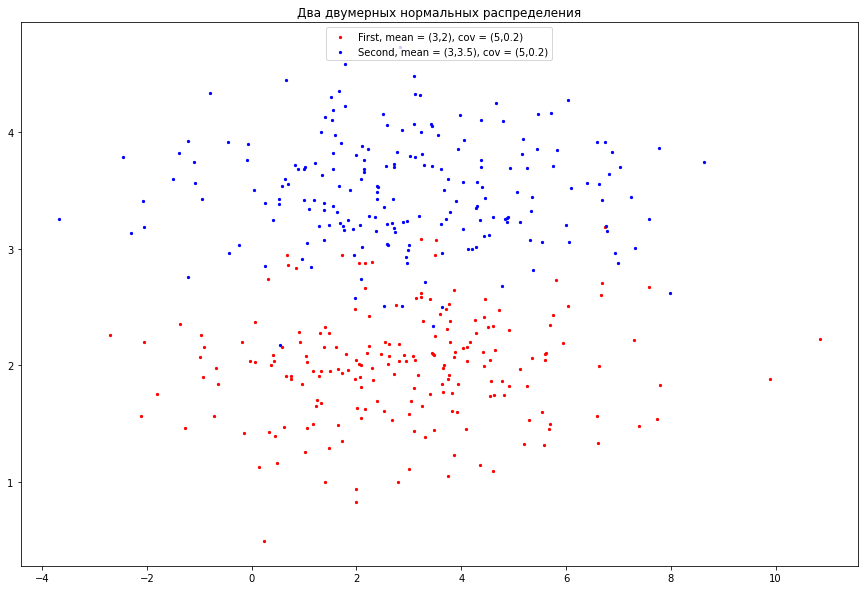

In [40]:
#Демонстрация исходных данных
reds = np.random.multivariate_normal((3,2),np.diag((5,0.2)), 200)
redst = reds.transpose()
blues = np.random.multivariate_normal((3,3.5),np.diag((5,0.2)), 200)
bluest = blues.transpose()

plt.scatter(redst[0],redst[1],s=5,c = 'red',label = 'First, mean = (3,2), cov = (5,0.2)')
plt.scatter(bluest[0],bluest[1],s=5,c = 'blue',label = 'Second, mean = (3,3.5), cov = (5,0.2)')
plt.legend(loc = 'upper center')
plt.title('Два двумерных нормальных распределения')
plt.show()

<function matplotlib.pyplot.show>

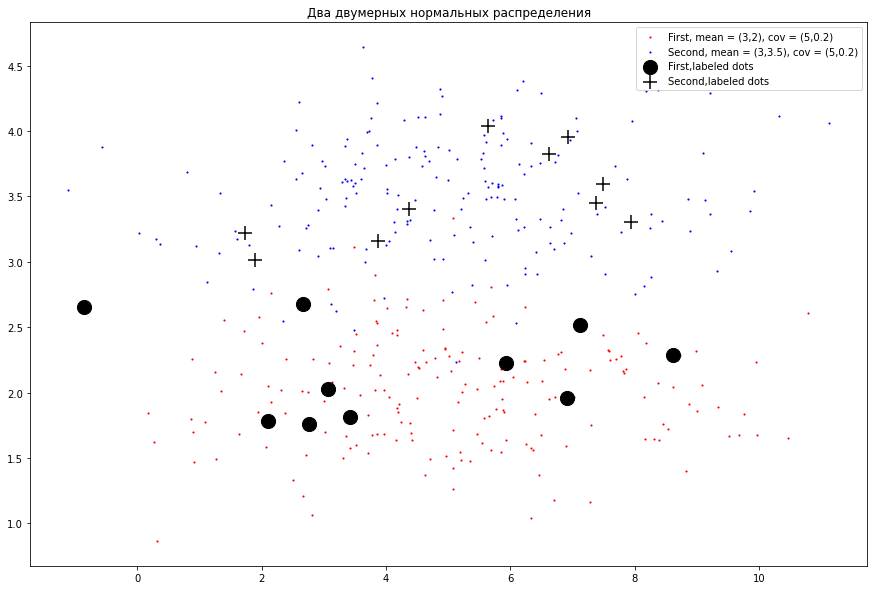

In [41]:
k_labeled = 10 ## То же самое, но с отмеченными k_labeled
reds = np.random.multivariate_normal((5,2),np.diag((5,0.2)), 200)
redst = reds.transpose()
blues = np.random.multivariate_normal((5,3.5),np.diag((5,0.2)), 200)
bluest = blues.transpose()
plt.scatter(redst[0][k_labeled:200],redst[1][k_labeled:200],marker = '.',s=5,c = 'red',label = 'First, mean = (3,2), cov = (5,0.2)')
plt.scatter(bluest[0][k_labeled:200],bluest[1][k_labeled:200],marker = '.',s=5,c = 'blue',label ='Second, mean = (3,3.5), cov = (5,0.2)')
plt.scatter(redst[0][0:k_labeled],redst[1][0:k_labeled],marker = 'o',s=200,c = 'black',label ='First,labeled dots')
plt.scatter(bluest[0][0:k_labeled],bluest[1][0:k_labeled],marker = '+',s=200,c = 'black',label ='Second,labeled dots')
plt.legend()
plt.title('Два двумерных нормальных распределения')
plt.show

Все до первого цикла в следующей функции - первый множитель $p(\theta|\hat{\theta})$ в формуле выше.
$$p(\theta|\hat{\theta}) = N( \theta |\hat{\theta}, \sigma(\alpha) )\prod_k N(\hat{\mu_k}| 0, (10 \hat{\Delta_k})^{-1}) G(\Delta_k|0.01,100)G(\hat{\Delta_k}|0.01,100) $$
$$\sigma(\alpha) = (\frac{\alpha}{1- \alpha})^2$$
$\alpha$ - выбираемый нами параметр. $\mu, \Delta$ - параметры распределений при генерации

In [11]:
def get_log_prob(rmu_11,rmu_21,rsigma_11,rsigma_21,rmu_12,rmu_22,rsigma_12,rsigma_22,bmu_11,bmu_21,bsigma_11,bsigma_21,bmu_12,bmu_22,bsigma_12,
                     bsigma_22, reds, blues, k_labeled, alpha): ##Считаем вышеописанное выражение для данных параметров
  ans = 0
  koef = (alpha/(1 - alpha))**2
  ans += multivariate_normal.logpdf((rmu_11,rmu_21,rsigma_11,rsigma_21,bmu_11,bmu_21,bsigma_11,bsigma_21),
                                    (rmu_12,rmu_22,rsigma_12,rsigma_22,bmu_12,bmu_22,bsigma_12,bsigma_22),np.diag((koef,koef,koef,koef,koef,koef,koef,koef)))
  ans += norm.logpdf(rmu_22,0, 1/(10*rsigma_22))
  ans += norm.logpdf(rmu_12,0, 1/(10*rsigma_12)) 
  ans += norm.logpdf(bmu_22,0, 1/(10*bsigma_22))
  ans += norm.logpdf(bmu_12,0, 1/(10*bsigma_12)) 
  ans += gamma.logpdf(rsigma_11,1, 0.01,100)
  ans += gamma.logpdf(rsigma_12,1, 0.01,100)
  ans += gamma.logpdf(rsigma_21,1, 0.01,100)
  ans += gamma.logpdf(rsigma_22,1, 0.01,100)
  ans += gamma.logpdf(bsigma_11,1, 0.01,100)
  ans += gamma.logpdf(bsigma_12,1, 0.01,100)
  ans += gamma.logpdf(bsigma_21,1, 0.01,100)
  ans += gamma.logpdf(bsigma_22,1, 0.01,100)
  for i in range(k_labeled):
    ans += multivariate_normal.logpdf(reds[i],[rmu_11,rmu_21],np.diag((rsigma_11,rsigma_21)))
    ans += multivariate_normal.logpdf(blues[i],[bmu_11,bmu_21],np.diag((bsigma_11,bsigma_21)))
    ans -= np.log(multivariate_normal.pdf(reds[i],[rmu_11,rmu_21],np.diag((rsigma_11,rsigma_21))) + 
                  multivariate_normal.pdf(reds[i],[bmu_11,bmu_21],np.diag((bsigma_11,bsigma_21))))
    ans -= np.log(multivariate_normal.pdf(blues[i],[rmu_11,rmu_21],np.diag((rsigma_11,rsigma_21))) + 
                  multivariate_normal.pdf(blues[i],[bmu_11,bmu_21],np.diag((bsigma_11,bsigma_21))))
  for i in range(100):
    rfirst = multivariate_normal.logpdf(reds[i],[rmu_12,rmu_22],np.diag((rsigma_12,rsigma_22)))
    rsecond = multivariate_normal.logpdf(reds[i],[rmu_12,rmu_22],np.diag((rsigma_12,rsigma_22)))
    bfirst = multivariate_normal.logpdf(reds[i],[rmu_12,rmu_22],np.diag((rsigma_12,rsigma_22)))
    bsecond = multivariate_normal.logpdf(reds[i],[rmu_12,rmu_22],np.diag((rsigma_12,rsigma_22)))
    ans += max(rfirst,rsecond)
    ans += max(bfirst,bsecond)
  return ans

In [35]:
def optimise(reds,blues,alpha,k_labeled): #Поиск оптимальных параметров. Просто перебор вдоль каждой оси
  rmu_11 = 3
  rmu_21 = 3
  rmu_22 = 3
  rmu_12 = 3
  bmu_11 = 3
  bmu_21 = 3
  bmu_22 = 3
  bmu_12 = 3
  rsigma_11 = 3
  rsigma_21 = 3
  rsigma_22 = 3
  rsigma_12 = 3
  bsigma_11 = 3
  bsigma_21 = 3
  bsigma_22 = 3
  bsigma_12 = 3
  currentlog = get_log_prob(rmu_11,rmu_21,rsigma_11,rsigma_21,rmu_12,rmu_22,rsigma_12,rsigma_22,bmu_11,bmu_21,bsigma_11,bsigma_21,bmu_12,bmu_22,bsigma_12,
                     bsigma_22, reds, blues, k_labeled, alpha)
  for i in tqdm(range(16)):
    for j in range(100):
      ans = get_log_prob((j+1)*0.1,rmu_21,rsigma_11,rsigma_21,rmu_12,rmu_22,rsigma_12,rsigma_22,bmu_11,bmu_21,bsigma_11,bsigma_21,bmu_12,bmu_22,bsigma_12,
                     bsigma_22, reds, blues, k_labeled, alpha)
      if(ans > currentlog):
        currentlog = ans
        rmu_11 = (j+1)*0.1
    for j in range(100):
      ans = get_log_prob(rmu_11,(j+1)*0.1,rsigma_11,rsigma_21,rmu_12,rmu_22,rsigma_12,rsigma_22,bmu_11,bmu_21,bsigma_11,bsigma_21,bmu_12,bmu_22,bsigma_12,
                     bsigma_22, reds, blues, k_labeled, alpha)
      if(ans > currentlog):
        currentlog = ans
        rmu_12 = (j+1)*0.1
    for j in range(100):
      ans = get_log_prob(rmu_11,rmu_21,(j+1)*0.1,rsigma_21,rmu_12,rmu_22,rsigma_12,rsigma_22,bmu_11,bmu_21,bsigma_11,bsigma_21,bmu_12,bmu_22,bsigma_12,
                     bsigma_22, reds, blues, k_labeled, alpha)
      if(ans > currentlog):
        currentlog = ans
        rsigma_11 = (j+1)*0.1
    for j in range(100):
      ans = get_log_prob(rmu_11,rmu_21,rsigma_11,(j+1)*0.1,rmu_12,rmu_22,rsigma_12,rsigma_22,bmu_11,bmu_21,bsigma_11,bsigma_21,bmu_12,bmu_22,bsigma_12,
                     bsigma_22, reds, blues, k_labeled, alpha)
      if(ans > currentlog):
        currentlog = ans
        rsigma_21 = (j+1)*0.1
    for j in range(100):
      ans = get_log_prob(rmu_11,rmu_21,rsigma_11,rsigma_21,(j+1)*0.1,rmu_22,rsigma_12,rsigma_22,bmu_11,bmu_21,bsigma_11,bsigma_21,bmu_12,bmu_22,bsigma_12,
                     bsigma_22, reds, blues, k_labeled, alpha)
      if(ans > currentlog):
        currentlog = ans
        rmu_12 = (j+1)*0.1
    for j in range(100):
      ans = get_log_prob(rmu_11,rmu_21,rsigma_11,rsigma_21,rmu_12,(j+1)*0.1,rsigma_12,rsigma_22,bmu_11,bmu_21,bsigma_11,bsigma_21,bmu_12,bmu_22,bsigma_12,
                     bsigma_22, reds, blues, k_labeled, alpha)
      if(ans > currentlog):
        currentlog = ans
        rmu_22 = (j+1)*0.1
    for j in range(100):
      ans = get_log_prob(rmu_11,rmu_21,rsigma_11,rsigma_21,rmu_12,rmu_22,(j+1)*0.1,rsigma_22,bmu_11,bmu_21,bsigma_11,bsigma_21,bmu_12,bmu_22,bsigma_12,
                     bsigma_22, reds, blues, k_labeled, alpha)
      if(ans > currentlog):
        currentlog = ans
        rsigma_12 = (j+1)*0.1
    for j in range(100):
      ans = get_log_prob(rmu_11,rmu_21,rsigma_11,rsigma_21,rmu_12,rmu_22,rsigma_12,(j+1)*0.1,bmu_11,bmu_21,bsigma_11,bsigma_21,bmu_12,bmu_22,bsigma_12,
                     bsigma_22, reds, blues, k_labeled, alpha)
      if(ans > currentlog):
        currentlog = ans
        rsigma_22 = (j+1)*0.1
    for j in range(100):
      ans = get_log_prob(rmu_11,rmu_21,rsigma_11,rsigma_21,rmu_12,rmu_22,rsigma_12,rsigma_22,(j+1)*0.1,bmu_21,bsigma_11,bsigma_21,bmu_12,bmu_22,bsigma_12,
                     bsigma_22, reds, blues, k_labeled, alpha)
      if(ans > currentlog):
        currentlog = ans
        bmu_11 = (j+1)*0.1
    for j in range(100):
      ans = get_log_prob(rmu_11,rmu_21,rsigma_11,rsigma_21,rmu_12,rmu_22,rsigma_12,rsigma_22,bmu_11,(j+1)*0.1,bsigma_11,bsigma_21,bmu_12,bmu_22,bsigma_12,
                     bsigma_22, reds, blues, k_labeled, alpha)
      if(ans > currentlog):
        currentlog = ans
        bmu_21 = (j+1)*0.1
    for j in range(100):
      ans = get_log_prob(rmu_11,rmu_21,rsigma_11,rsigma_21,rmu_12,rmu_22,rsigma_12,rsigma_22,bmu_11,bmu_21,(j+1)*0.1,bsigma_21,bmu_12,bmu_22,bsigma_12,
                     bsigma_22, reds, blues, k_labeled, alpha)
      if(ans > currentlog):
        currentlog = ans
        bsigma_11 = (j+1)*0.1
    for j in range(100):
      ans = get_log_prob(rmu_11,rmu_21,rsigma_11,rsigma_21,rmu_12,rmu_22,rsigma_12,rsigma_22,bmu_11,bmu_21,bsigma_11,(j+1)*0.1,bmu_12,bmu_22,bsigma_12,
                     bsigma_22, reds, blues, k_labeled, alpha)
      if(ans > currentlog):
        currentlog = ans
        bsigma_21 = (j+1)*0.1
    for j in range(100):
      ans = get_log_prob(rmu_11,rmu_21,rsigma_11,rsigma_21,rmu_12,rmu_22,rsigma_12,rsigma_22,bmu_11,bmu_21,bsigma_11,bsigma_21,(j+1)*0.1,bmu_22,bsigma_12,
                     bsigma_22, reds, blues, k_labeled, alpha)
      if(ans > currentlog):
        currentlog = ans
        bmu_12 = (j+1)*0.1
    for j in range(100):
      ans = get_log_prob(rmu_11,rmu_21,rsigma_11,rsigma_21,rmu_12,rmu_22,rsigma_12,rsigma_22,bmu_11,bmu_21,bsigma_11,bsigma_21,bmu_12,(j+1)*0.1,bsigma_12,
                     bsigma_22, reds, blues, k_labeled, alpha)
      if(ans > currentlog):
        currentlog = ans
        bmu_22 = (j+1)*0.1
    for j in range(100):
      ans = get_log_prob(rmu_11,rmu_21,rsigma_11,rsigma_21,rmu_12,rmu_22,rsigma_12,rsigma_22,bmu_11,bmu_21,bsigma_11,bsigma_21,bmu_12,bmu_22,(j+1)*0.1,
                     bsigma_22, reds, blues, k_labeled, alpha)
      if(ans > currentlog):
        currentlog = ans
        bsigma_12 = (j+1)*0.1
    for j in range(100):
      ans = get_log_prob(rmu_11,rmu_21,rsigma_11,rsigma_21,rmu_12,rmu_22,rsigma_12,rsigma_22,bmu_11,bmu_21,bsigma_11,bsigma_21,bmu_12,bmu_22,bsigma_12,
                     (j+1)*0.1, reds, blues, k_labeled, alpha)
      if(ans > currentlog):
        currentlog = ans
        bsigma_22 = (j+1)*0.1
  return(rmu_11,rmu_21,rsigma_11,rsigma_21,rmu_12,rmu_22,rsigma_12,rsigma_22,bmu_11,bmu_21,bsigma_11,bsigma_21,bmu_12,bmu_22,bsigma_12,
                     bsigma_22)

In [32]:
def for_interactionBishop(alpha,k_labeled): ## Соединение всего вышенаписанного в одну интерактивную функцию
  reds = np.random.multivariate_normal((5,2),np.diag((5,0.2)), 200)
  blues = np.random.multivariate_normal((5,3.5),np.diag((5,0.2)), 200)

  rmu_11,rmu_21,rsigma_11,rsigma_21,rmu_12,rmu_22,rsigma_12,rsigma_22,bmu_11,bmu_21,bsigma_11,bsigma_21,bmu_12,bmu_22,bsigma_12,bsigma_22 = optimise(reds,blues,alpha,k_labeled)
  fig, ax = plt.subplots()
  plt.scatter(redst[0][k_labeled:200],redst[1][k_labeled:200],marker = '.',s=5,c = 'red',label = 'First, mean = (3,2), cov = (5,0.2)')
  plt.scatter(bluest[0][k_labeled:200],bluest[1][k_labeled:200],marker = '.',s=5,c = 'blue',label ='Second, mean = (3,3.5), cov = (5,0.2)')
  plt.scatter([rmu_11,bmu_11],[rmu_21,bmu_21],marker = 'o',s=200,c = 'black')
  for i in tqdm(range(150)):
    for j in range(100):
      if (multivariate_normal.pdf((i*0.1 -3 , j*0.05),(rmu_11,rmu_21),np.diag((rsigma_11,rsigma_21))) <= multivariate_normal.pdf((i*0.1 - 3 , j*0.05),(bmu_11,bmu_21),np.diag((bsigma_11,bsigma_21)))):
        ax.add_patch(Rectangle((i*0.1 -3,j*0.05), 0.1, 0.05,facecolor = 'yellow', fill = False))
  plt.legend(loc = 'upper center')
  plt.title('Разделяющая поверхность')
  plt.show

In [33]:
interact(for_interactionBishop,alpha = widgets.FloatSlider(value = 0.3,
                                               min = 0.01,
                                               max = 0.99,
                                               step = 0.01),
                              k_labeled = widgets.IntSlider(value = 10,
                                               min = 1,
                                               max = 100,
                                               step = 1))

interactive(children=(FloatSlider(value=0.3, description='alpha', max=0.99, min=0.01, step=0.01), IntSlider(va…

<function __main__.for_interactionBishop>

Примеры далее приведены для 2 отмеченных(labeled) точек каждого цвета и $\alpha = 0.01,0.99,0.4$

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

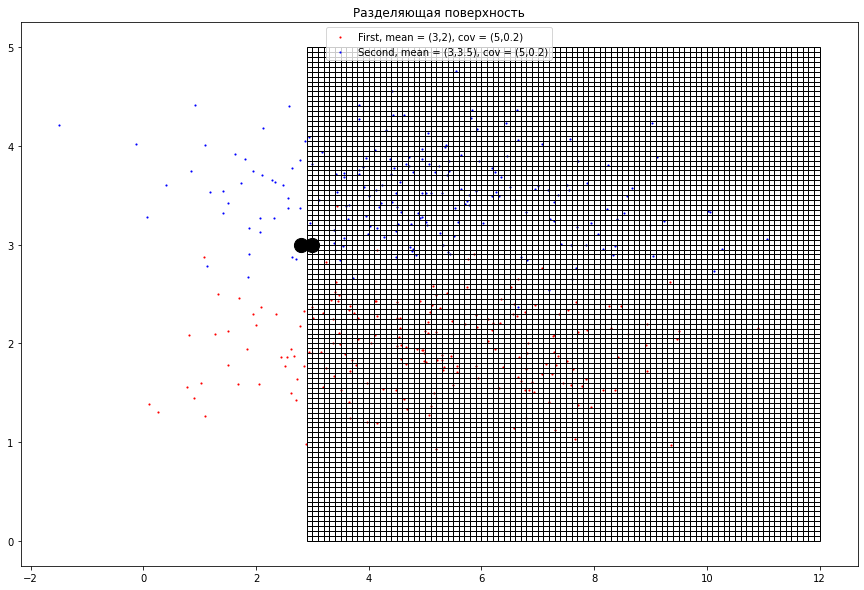

In [36]:
for_interactionBishop(0.01,2)
#График для alpha = 0.01

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

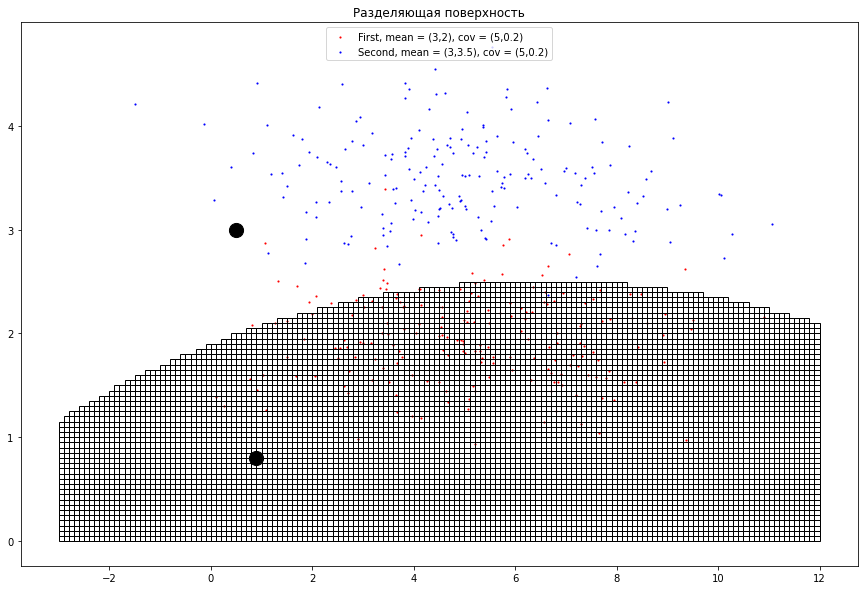

In [38]:
for_interactionBishop(0.4,2)
#График для alpha = 0.4

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

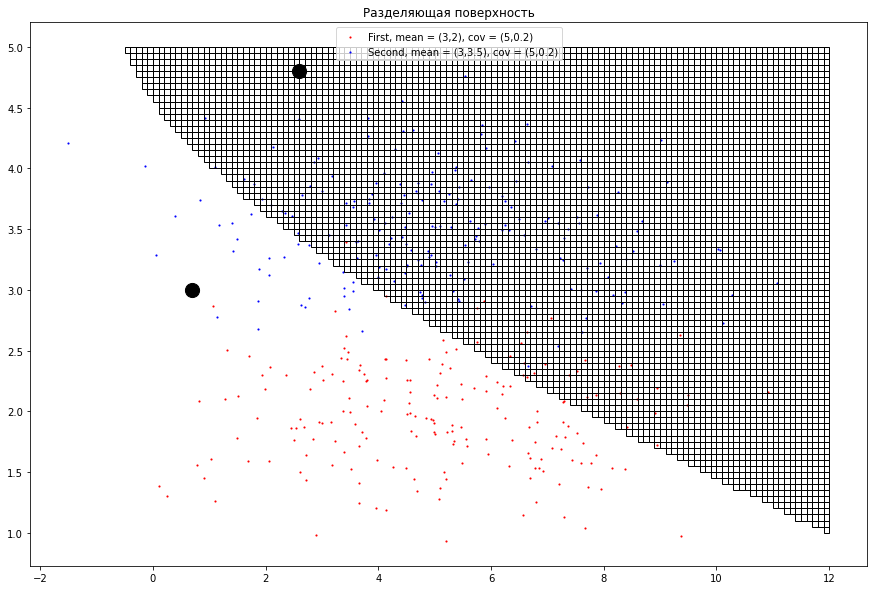

In [39]:
for_interactionBishop(0.99,2)
#График для alpha = 0.99

Вывод здесь мало чем может отличаться от того, что в статье. Результаты иногда имеют иной вид, но чаще всего получается что-то похожее на то, что в статье и то, что показано выше, то есть -- при близких к нулю точки разделены пополам вне зависимости от их принадлежности, а при близких к единице разделение точек скорее опирается на отмеченные(хотя последний график построен так, что это невозможно заметить, все равно видно, что разделение в целом соответствует действительности, но наклонено немного под другим углом). 